In [27]:
from importlib import reload
import utils_functions
reload(utils_functions)

<module 'utils_functions' from 'c:\\Users\\valen\\OneDrive\\Documents\\MA 3\\CS 401\\ada-2024-project-abracadabra\\utils_functions.py'>

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from utils_functions import classify_user_rating_level, plot_category_distrib, PCA_plot, compute_variance_per_attribute

# Part 1 Understanding and treating the data

## Part 1.1 Data conversion

The first step in our analysis is to ensure all data is represented consistently across the project. This involves converting the original **.txt** files containing ratings and reviews into **.csv** format. Each file was examined carefully, the strings were stored into dictionaries representing key data fiels. More details on the conversion process and methodology can be found in ????????

## Part 1.2 Data exploration

With the data now in a consistent format, we begin exploring deeper the datasets to understand their links and features. We learn especially that some breweries, beers, users matches between the websites. Moreover, their might be duplicates within the datasets, with some users having multiple account. DO I MISS SOMETHING???. Further explanations can be found in ????? data_understanding... EXPLAIN THE FEATURES ?

Some rows contain NaN values in the datasets. Since certain parts of the analysis do not require every feature, we handle missing data filtering it based on the requirements of each analysis section.

## Part 1.3 Dataset merging
To enhance the robustness of the analysis, we merge data from both RateBeer and BeerAdvocate. This approach increases the number of ratings per beer enabling a higher reliability and enhancing the controversiality analysis.

We must first perform a little analysis to ensure compatibility between the two dataset. For example, we noticed that websites had different scale for the ratings. This is thus necessary to convert them into a similar one.

When merging, we must be careful and take into account the different matched data between the two datasets, such as users, breweries etc...

EXPLAIN DEEPER HOW THIS IS DONE



In [5]:
root = Path(os.getcwd()).parent

#Change for each one of where your data is. For me in Dataset I have all the three folders
dataset_path = os.path.join(root,'Dataset')

FULL = "full"
FULL_PATH = os.path.join(dataset_path,FULL)

ratings = pd.read_csv(os.path.join(FULL_PATH,'ratings.csv'))

In [30]:
ratings.head()

,date,appearance,aroma,palate,taste,overall,rating,text,dataset,id,id_brewery,id_user,id_beer,matched,var_appearance,var_aroma,var_palate,var_taste,var_overall,var_rating
1,1487329200,2.0,3.0,2.0,4.0,8.0,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...,rb,2,16713,3295.0,45642,NaN,0.918937,0.823273,0.788811,0.849837,1.37032,0.314289
2,1466762400,3.0,3.0,2.0,3.0,5.0,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni...",rb,3,16713,3318.0,45642,NaN,0.918937,0.823273,0.788811,0.849837,1.37032,0.314289
3,1451646000,4.0,3.0,1.0,2.0,5.0,1.5,"Botella, de GabÃ³n regalo familiar.31/01/2015C...",rb,4,16713,3319.0,45642,NaN,0.918937,0.823273,0.788811,0.849837,1.37032,0.314289
4,1445594400,2.0,4.0,2.0,4.0,7.0,1.9,Many thanks for this beer to Erzengel. Pours l...,rb,5,16713,3320.0,45642,NaN,0.918937,0.823273,0.788811,0.849837,1.37032,0.314289
5,1444644000,2.0,3.0,2.0,3.0,9.0,1.9,Many thanks to Erzengel for sharing! Pours cle...,rb,6,16713,3321.0,45642,NaN,0.918937,0.823273,0.788811,0.849837,1.37032,0.314289


In [29]:
ratings = compute_variance_per_attribute(ratings)

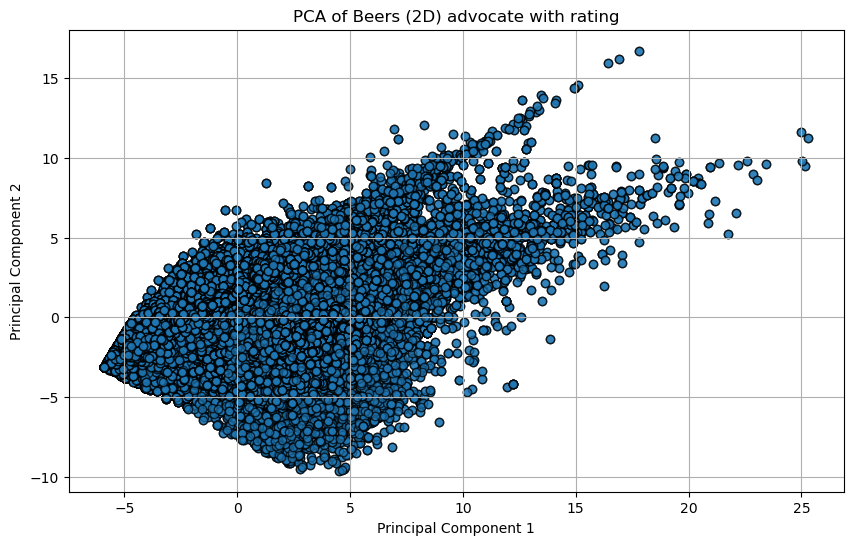

principal components: [[ 0.39161944  0.46136695  0.39416917  0.46896944  0.42713622  0.27573127]
 [ 0.28651697 -0.29742703  0.40496988 -0.25470006 -0.4450472   0.63443318]]
Explained variance [0.67478088 0.18323544]


In [31]:
PCA_plot(ratings)

# Part 2 Exploring the definition of controversiality

This part aims to determine and label which beers are controversial and which are universal. To do this, we explore different aspects defining the controversiality of a beer. 

What does controversial mean : "giving rise or likely to give rise to controversy or public disagreement". As described, this depends on the opinions of the people. As a result, this analysis only depends on the fields the users can fulfill, namely, the different ratings : appearance, aroma, palate, taste, overall, and the textual reviews

## Part 2.1 Ratings and reviews filtering

As mentioned earlier, controversiality depends on disagreement in opinions. Beers with few ratings are more likely to show high variability (e.g. two opposing opinions). To ensure reliable insights and meaningful analysis, we exclude beers with fewer number of ratings or reviews than a specified threshold. Later, we might apply a weighting factor based on rating count to further refine the controversiality analysis, according more importance to more rated beers.

The threshold deciding wheter to keep a beer in the analysis is chosen arbitrarily.

In [1]:
# Create dataset filtering beer with too few ratings for the part 2.2
# Create dataset filtering beer with too few textual review for the part 2.3

## Part 2.2 Features controversiality analysis

Controversiality can be analyzed in different manners. For now, the three following definitions are studied :

- We compute the variance of each attributes for each beer, then study which attribute seems to be the more controversial by looking at the distribution of the variances.
- We compute the variance across the **overall** rating, provided by the user. We then classify beers as controversial if above a certain threshold. Then, we observe which of the four main attributes influences the most the overall score controversiality.
- We count for each beer which attributes is the most and lest controversial.



WE COULD APPLY A WEIGHT AS A FUNCTION OF THE NUMBER OF RATINGS ????

### Part 2.2.1 Features analysis controversiality

In [ ]:
# compute variance of each attributes on each beer
# describe it
# violin plot box plot

### Part 2.2.2 Features analysis from overall controversiality

In [ ]:
# classify controversiality as a function of overall variance with threshold or %
# describe it
# box plot

### Part 2.2.3 Feature analysis from count

In [ ]:
# count number of max min variance attributes

### Part 2.2.4 Correlation between the variance of the attributes

In [2]:
# Correlation of the attribute's variances with overall variance

## Part 2.3 Sentimental analysis of the reviews

## Part 2.4 Which beer is controversial then ?

### Part 2.4.1 Labelling

### Part 2.4.2 Statistical testing and validation

# Part 3 Some reasons of controversiality

This part uses the label attributed to the beers. It tries to find patterns and reasons of controversial opinion as a function of "constant" variables such as abv and style of the beer, location of the brewery and the users, level of expertise of the users...

## Part 3.1 Novice/Enthusiasts/Connoisseur analysis

In this part, we classify the users related to how many ratings they did.

- Novice are users with only a few ratings : 1-20.
- Enthusiasts are users with moderate number of ratings : 21-100
- Connoisseur are users with high nuber of ratings . 101+

It is important to note that this choice has been arbitrarily made. It could be made differently or could be interactive for the reader of the story, enabling him to label users differently according to how many ratings he thinks is enough to be a connoisseur/enthusiasts/novice.

Another essential thing to take into account is that these classes do not represent users as novice or connoisseur about **beers**, but about **rating** on these particular website.

First step is to classify the users in the three mentioned categories.

In [ ]:
user_df = classify_user_rating_level(user_df, enthusiasts_level=21, connoisseur_level=101)
plot_category_distrib(user_df, 'rating_user_level')

## Part 3.2 Style of the beer and abv

## Part 3.2 Patterns in location and ratings of local or foreign beers

In [ ]:
# Under construction